In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("processed_dataset.csv")

In [2]:
from collections import Counter

def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [3]:
text = list(df['text'])
headlines = list(df['headline'])
temp = []
temp.extend(text)
temp.extend(headlines)

vocab, vocabcount = get_vocab(temp)
vocabcount = {k: v for k, v in sorted(vocabcount.items(), key=lambda item: item[1])}

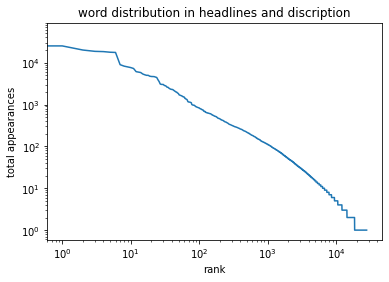

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 400
headlines_len = 20
max_words = 25000

text_tokenizer = Tokenizer(num_words = max_words)
text_tokenizer.fit_on_texts(temp)
text_sequences = pad_sequences(text_tokenizer.texts_to_sequences(text), maxlen = maxlen, padding='pre')
headline_sequences = pad_sequences(text_tokenizer.texts_to_sequences(headlines), maxlen = headlines_len, padding='pre')

word_index = text_tokenizer.word_index


In [7]:
embedding_dict = {}

with open("../glove/archive/glove.6B.100d.txt", "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],"float32")
        embedding_dict[word] = vectors
f.close()

embedding_dim = 100
num_words = max_words + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, Activation
from keras.initializers import Constant

def build_model(embeddings):
    lstm_size = 100
    p_dense = 0.2
    
    
    model = Sequential()
#     model.add(Embedding(num_words,100, weights = [embedding_matrix], input_length = maxlen, trainable = False))
    model.add(Embedding(weights = [embedding_matrix], trainable = False))
    
    model.add(LSTM(64, input_shape = (400,100), return_sequences= True))
    model.add(LSTM(64, return_sequences = True))
    model.add(LSTM(32))
    model.add(Dense(32, activation="softmax"))

    return model


In [13]:
encoder = build_model(embedding_matrix)
encoder.compile(loss='categorical_crossentropy', optimizer = 'rmsprop')
encoder.save_weights('embeddings.pkl', overwrite = True)

TypeError: __init__() missing 2 required positional arguments: 'input_dim' and 'output_dim'

In [23]:
import pickle
with open('embeddings.pkl', 'rb') as fp:
    embeddings = pickle.load(fp)

array([916, 346, 435, 397, 692,  65, 362, 590, 275, 906])

(100000, 300)